# Section 1: Introduction

Main Objective:
My main objective is to develop a deep learning model that predicts the stock price of a key technology company Microsoft. 
By analyzing historical stock data, I aim to forecast future price movements and identify potential investment opportunities within the technology sector.

Data Description:
I will be using the yfinance library to collect historical stock price data for the selected technology companies. This dataset will include daily open, high, low, close prices, as well as trading volume and adjusted close prices. 
The data will cover a specified time period from'2014-01-01' to '2024-06-01', allowing for the analysis of trends and patterns in stock price movements.

We begin by importing the required libraries including 'yfinance' for data collection

In [227]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional


We set the name to 'MSFT' which indicates for Microsoft stock then set the time period

In [230]:
# Define the name of the technology stock
tech_stock = 'MSFT'

# Define the start and end dates for data collection
start_date = '2014-01-01'
end_date = '2024-06-01'

We download and collect historical stock price data for Microsoft for the specified time period using the yfinance library, then we save it to a csv file locally for later access

In [231]:
# Collect historical stock price data for the selected companies
#stock_data = yf.download(tech_stock, start=start_date, end=end_date)
# Saving the data to a CSV file
#csv_file = 'stock_data.csv'
#stock_data.to_csv(csv_file)
#print(f"Data saved to {csv_file}")

In [232]:
# Loading the data
stock_data = pd.read_csv('stock_data.csv')

The shape indicates we have 2621 data samples to work with

In [240]:
stock_data.shape

(2621, 7)

Data Collection: Historical stock price data was successfully collected Microsoft (MSFT)

We view the first five rows and we see each data point has attributes Date, Open, High, Low, Close, Adj Close, Volume.

All columns are of the float datatype except for Date which is an object representing the date and the Volume which is an integere

In [251]:
stock_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,37.349998,37.400002,37.099998,37.160000,31.176825,30632200
1,2014-01-03,37.200001,37.220001,36.599998,36.910000,30.967089,31134800
2,2014-01-06,36.849998,36.889999,36.110001,36.130001,30.312677,43603700
3,2014-01-07,36.330002,36.490002,36.209999,36.410000,30.547586,35802800
4,2014-01-08,36.000000,36.139999,35.580002,35.759998,30.002234,59971700


In [252]:
stock_data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

During the exploration phase, I visualized the time series data to identify any trends, seasonality, or anomalies. 

Trend Analysis: The stock exhibits a clear uptrend overtime.                                                                

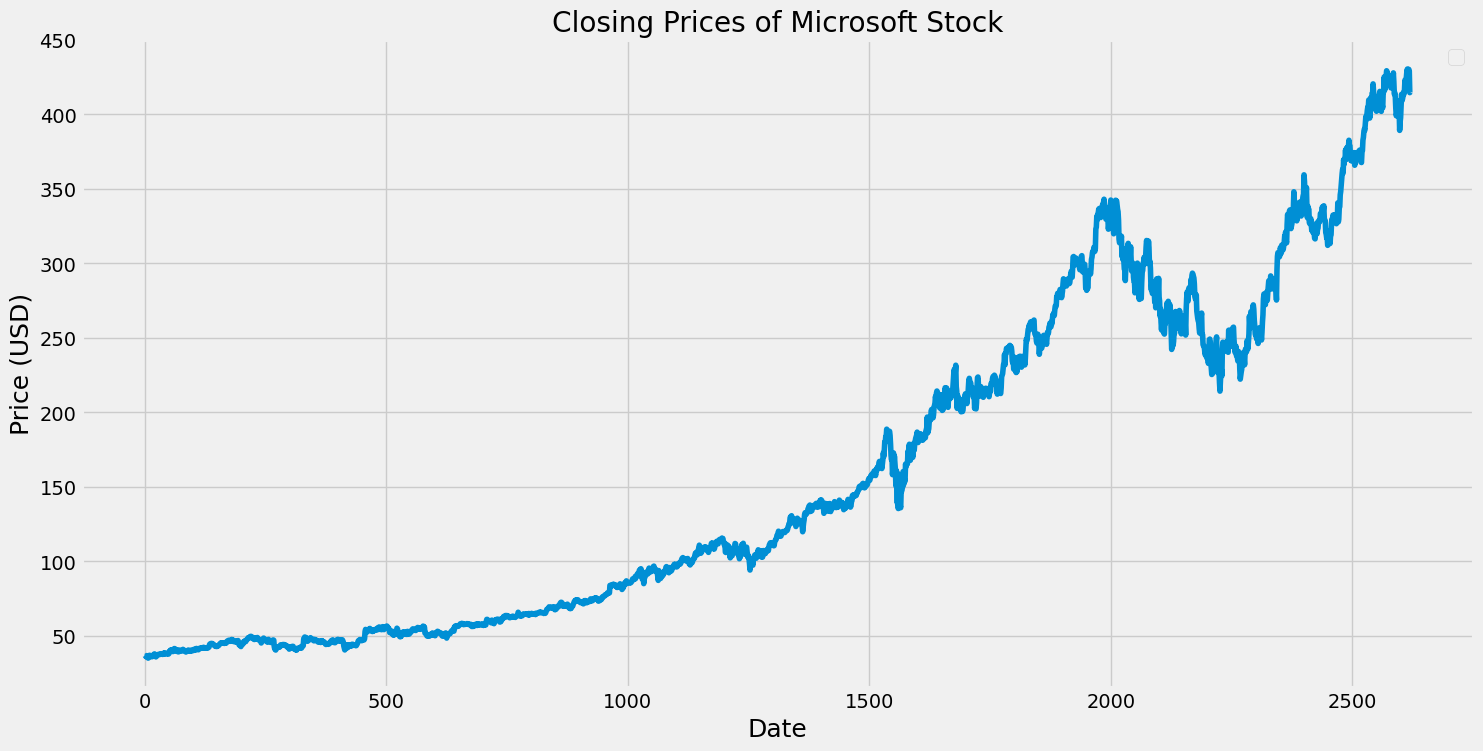

In [253]:
# Visualize the closing prices of the stocks
plt.figure(figsize=(16, 8))

plt.plot(stock_data['Close'])
plt.title('Closing Prices of Microsoft Stock')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.legend()
plt.show()

Additionally, I checked for missing values and outliers that might affect the quality of the data.
Missing Values: No missing values were found in the dataset, eliminating the need for data imputation or removal.

In [246]:
# Check for missing values
stock_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Distribution of Daily Returns: The distribution of daily returns for each stock appeared to follow a normal distribution centered around 0.0

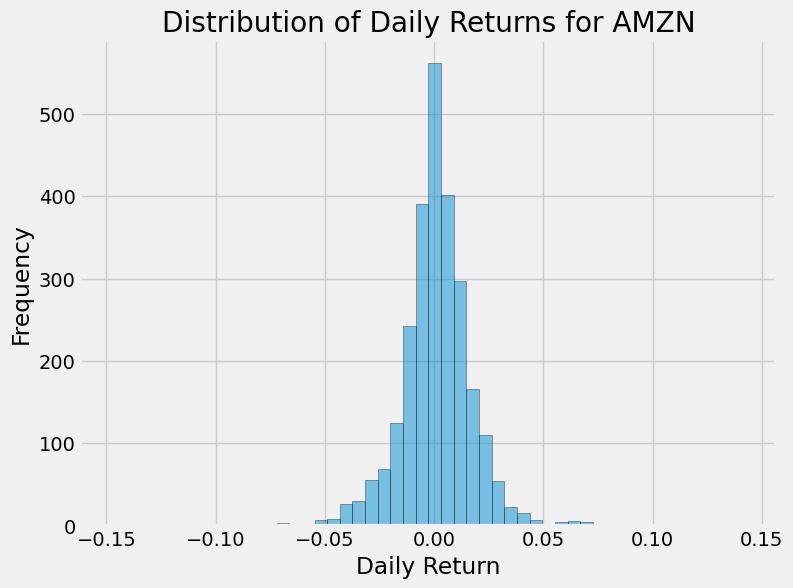

In [249]:
# Calculate daily returns
returns = stock_data['Close'].pct_change()

# Plot histogram for Amazon (AMZN)
plt.figure(figsize=(8, 6))
plt.hist(returns, bins=50, edgecolor='k', alpha=0.5)
plt.title('Distribution of Daily Returns for AMZN')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


For our analysis we chose to focus on only the closing price

In [254]:
##### Create a new df with only the close column
data = stock_data[['Close']]
# Convert the dataframe to a numpy array
dataset = data.values

We scale the closing prices to values between 0 and 1 using MinMaxScaler

In [184]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

We split our data into train and test set.

We set the size of the training data to be 80% of the original dataset and then perfom the split

In [255]:
# Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) * .8)
validation_data_len = len(dataset) - training_data_len
training_data_len, validation_data_len

(2097, 524)

In [257]:
# Create the training dataset
train_data = scaled_data[0:training_data_len, :]
# split the data into x_train and y_train
X_train =[]
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60: i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
X_train, y_train = np.array(X_train) ,np.array(y_train) 
# Reshape the data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train.shape, y_train.shape

((2037, 60, 1), (2037,))

The new shape indicates we now have 2037 rows to work with for the training process

In [258]:
# Create the testing dataset
# Create a new array vontaining scaled values fro index 1543 to 2993
test_data = scaled_data[training_data_len - 60 : ,:]
# Create the data sets
# split the data into x_train and y_train
X_test =[]
y_test= []

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60: i, 0])
    y_test.append(test_data[i, 0])
 

# Convert the x_train and y_train to numpy arrays
X_test, y_test = np.array(X_test) ,np.array(y_test) 
# Reshape the data
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test.shape, y_test.shape

((524, 60, 1), (524,))

We now also have 520 rows for the testing process, which is the 20% we specified

## Section 3: Model Variations

Introduction:

In this section, we delve into the technical details of three variations of deep learning models for stock price prediction: Basic LSTM Model, Deeper LSTM Model, and Bidirectional LSTM Model.

Model Variations:

Basic LSTM Model:

Architecture: Employs a single LSTM layer with dropout regularization, followed by a dense output layer.

Technical Details: LSTM (Long Short-Term Memory) units are utilized to capture temporal dependencies in sequential data. 
Dropout is applied to prevent overfitting by randomly dropping a fraction of input units during training.

Deeper LSTM Model:

Architecture: Incorporates multiple LSTM layers stacked on top of each other, with dropout regularization and a dense output layer.

Technical Details: The deeper architecture allows for the extraction of more intricate patterns and features from the input data. 
Dropout layers are interspersed between LSTM layers to mitigate overfitting and improve model generalization.

Bidirectional LSTM Model:

Architecture: Utilizes a bidirectional LSTM layer, which processes input sequences in both forward and backward directions, followed by dropout regularization and a dense output layer.

Technical Details: Bidirectional LSTM enables the model to capture dependencies from past and future time steps, enhancing its ability to understand sequential patterns. 
Dropout is employed to reduce overfitting and improve the model's robustness.

We used a batch size of 32 and 50 epochs for each model variation

We also utilized, for all models, early stopping callback with a focus on the training loss every five steps

In [260]:

# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
batch_size = 32
epochs = 50

In [210]:
# Define the LSTM model architecture
# Variation 1: Basic LSTM Model
basic_lstm_model = Sequential(name='Basic_LSTM_Model')
basic_lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
basic_lstm_model.add(Dropout(0.2))
basic_lstm_model.add(LSTM(units=50))
basic_lstm_model.add(Dropout(0.2))
basic_lstm_model.add(Dense(units=1))


# Compile the model
basic_lstm_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

basic_lstm_model.summary()

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Basic_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [211]:
# Train the model
history_basic_lstm = basic_lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.0179 - root_mean_squared_error: 0.1268
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.0011 - root_mean_squared_error: 0.0338
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 9.1393e-04 - root_mean_squared_error: 0.0301
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 9.2272e-04 - root_mean_squared_error: 0.0303
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 9.0749e-04 - root_mean_squared_error: 0.0301
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0011 - root_mean_squared_error: 0.0338
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 8.5627e-04 - root_mean_squared_error: 0.0292
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 7.9190e-04 - root_mean_squared_error: 0.0281
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 8.3818e-04 - root_m

In [212]:
# Variation 2: Deeper LSTM Model
# Define the deeper LSTM model architecture
deeper_lstm_model = Sequential(name='Deeper_LSTM_Model')
deeper_lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
deeper_lstm_model.add(Dropout(0.2))
deeper_lstm_model.add(LSTM(units=50, return_sequences=True))
deeper_lstm_model.add(Dropout(0.2))
deeper_lstm_model.add(LSTM(units=50))
deeper_lstm_model.add(Dropout(0.2))
deeper_lstm_model.add(Dense(units=1))

# Compile the model
deeper_lstm_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Print model summary with name
deeper_lstm_model.summary()

Model: "Deeper_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_41 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_42 (LSTM)                       │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_43 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [213]:
# Train the model
history_deeper_lstm = deeper_lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - loss: 0.0232 - root_mean_squared_error: 0.1426
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.0011 - root_mean_squared_error: 0.0336
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335


In [214]:
# Variation 3:  Bidirectional LSTM Model
# Define the Bidirectional LSTM model architecture
bidirectional_lstm_model = Sequential(name='Bidirectional_LSTM_Model')
bidirectional_lstm_model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
bidirectional_lstm_model.add(Dropout(0.2))
bidirectional_lstm_model.add(LSTM(units=50))
bidirectional_lstm_model.add(Dropout(0.2))
bidirectional_lstm_model.add(Dense(units=1))

# Compile the model
bidirectional_lstm_model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
# Print model summary with name
bidirectional_lstm_model.summary()

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Bidirectional_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 60, 100)             │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_45 (LSTM)                       │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,051 (199.42 KB)

 Trainable params: 51,051 (199.42 KB)

 Non-trainable params: 0 (0.00 B)

In [215]:
# Train the model with early stopping
history_bidirectional_lstm = bidirectional_lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - loss: 0.0215 - root_mean_squared_error: 0.1373
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 9.6754e-04 - root_mean_squared_error: 0.0310
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 9.6980e-04 - root_mean_squared_error: 0.0311
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 6.6421e-04 - root_mean_squared_error: 0.0257
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 7.1761e-04 - root_mean_squared_error: 0.0267


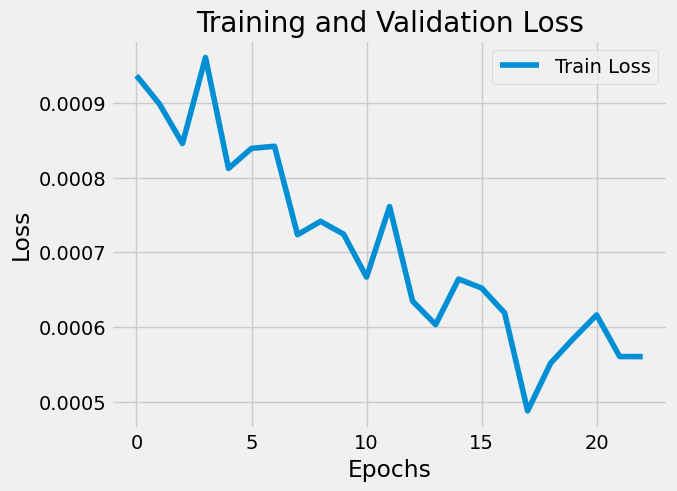

In [217]:
# Plotting the train and validation loss
plt.plot(history_basic_lstm.history["loss"][3:], label="Train Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

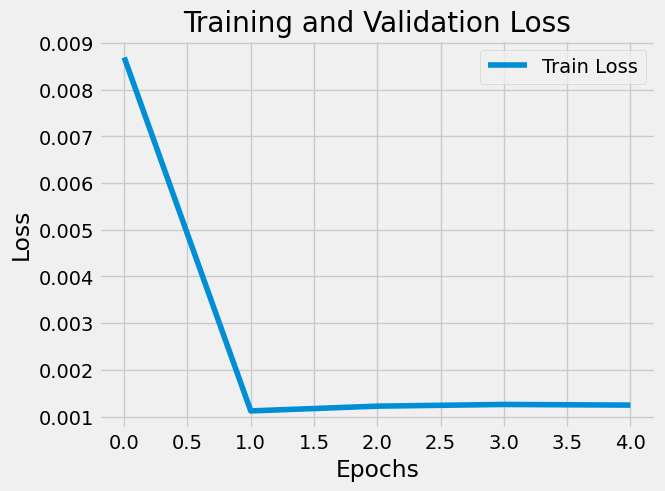

In [218]:
# Plotting the train and validation loss
plt.plot(history_deeper_lstm.history["loss"], label="Train Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

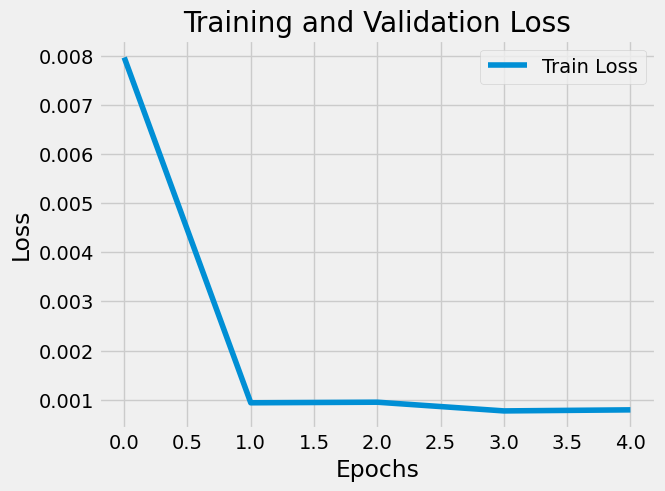

In [219]:
# Plotting the train and validation loss
plt.plot(history_bidirectional_lstm.history["loss"], label="Train Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Section 4: Model Evaluation

Introduction:

This section evaluates the performance of each model variation through quantitative metrics, including Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE).

In [262]:

# Evaluate Basic LSTM Model
y_pred_basic_lstm = basic_lstm_model.predict(X_test)
mse_basic_lstm = mean_squared_error(y_test, y_pred_basic_lstm)
rmse_basic_lstm = math.sqrt(mse_basic_lstm)
mae_basic_lstm = mean_absolute_error(y_test, y_pred_basic_lstm)

# Evaluate Deeper LSTM Model
y_pred_deeper_lstm = deeper_lstm_model.predict(X_test)
mse_deeper_lstm = mean_squared_error(y_test, y_pred_deeper_lstm)
rmse_deeper_lstm = math.sqrt(mse_deeper_lstm)
mae_deeper_lstm = mean_absolute_error(y_test, y_pred_deeper_lstm)

# Evaluate Bidirectional LSTM Model
y_pred_bidirectional_lstm = bidirectional_lstm_model.predict(X_test)
mse_bidirectional_lstm = mean_squared_error(y_test, y_pred_bidirectional_lstm)
rmse_bidirectional_lstm = math.sqrt(mse_bidirectional_lstm)
mae_bidirectional_lstm = mean_absolute_error(y_test, y_pred_bidirectional_lstm)

print("Basic LSTM Model:")
print(f"MSE: {mse_basic_lstm}")
print(f"RMSE: {rmse_basic_lstm}")
print(f"MAE: {mae_basic_lstm}")

print("\nDeeper LSTM Model:")
print(f"MSE: {mse_deeper_lstm}")
print(f"RMSE: {rmse_deeper_lstm}")
print(f"MAE: {mae_deeper_lstm}")

print("\nBidirectional LSTM Model:")
print(f"MSE: {mse_bidirectional_lstm}")
print(f"RMSE: {rmse_bidirectional_lstm}")
print(f"MAE: {mae_bidirectional_lstm}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Basic LSTM Model:
MSE: 0.001388942629546815
RMSE: 0.037268520624607775
MAE: 0.031564800019289824

Deeper LSTM Model:
MSE: 0.0014962237401684056
RMSE: 0.038681051435662986
MAE: 0.03265327007468515

Bidirectional LSTM Model:
MSE: 0.0014879614633684706
RMSE: 0.03857410353292051
MAE: 0.03263122436592763


### Model Variations and Selection:

    Basic LSTM Model: Demonstrated the best performance in predicting stock closing prices.
    Deeper LSTM Model: Increased complexity resulted in higher error rates, indicating overfitting.
    Bidirectional LSTM Model: Slight improvements over the Deeper LSTM but not as effective as the Basic LSTM.
    Chosen Model: Basic LSTM is identified as the best-suited model for the main objective due to its superior performance.

In [221]:
basic_lstm_model.save('price_predictor_model.h5')

In [222]:
from keras.models import load_model

In [ ]:
# Load the trained model
model = load_model('price_predictor_model.h5')  # Change 'path_to_your_saved_model.h5' to the actual path
num_features = X_test.shape[2]

# Predictions from the model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]

valid['predictions'] = predictions

After making preductions on a test set, we compare the predictions side by side

In [263]:
# Show the valid and predicted
valid

,Close,predictions
2097,284.470001,274.915741
2098,281.779999,275.104187
2099,289.980011,275.300385
2100,277.350006,276.061493
2101,274.730011,276.220703
...,...,...
2616,430.160004,402.682587
2617,430.320007,404.015747
2618,429.170013,405.189453
2619,414.670013,406.096497


We plot the trend line to visualize how well our model is actually doing on new unseen data ( validation vs predictions )

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12736\2383173505.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions


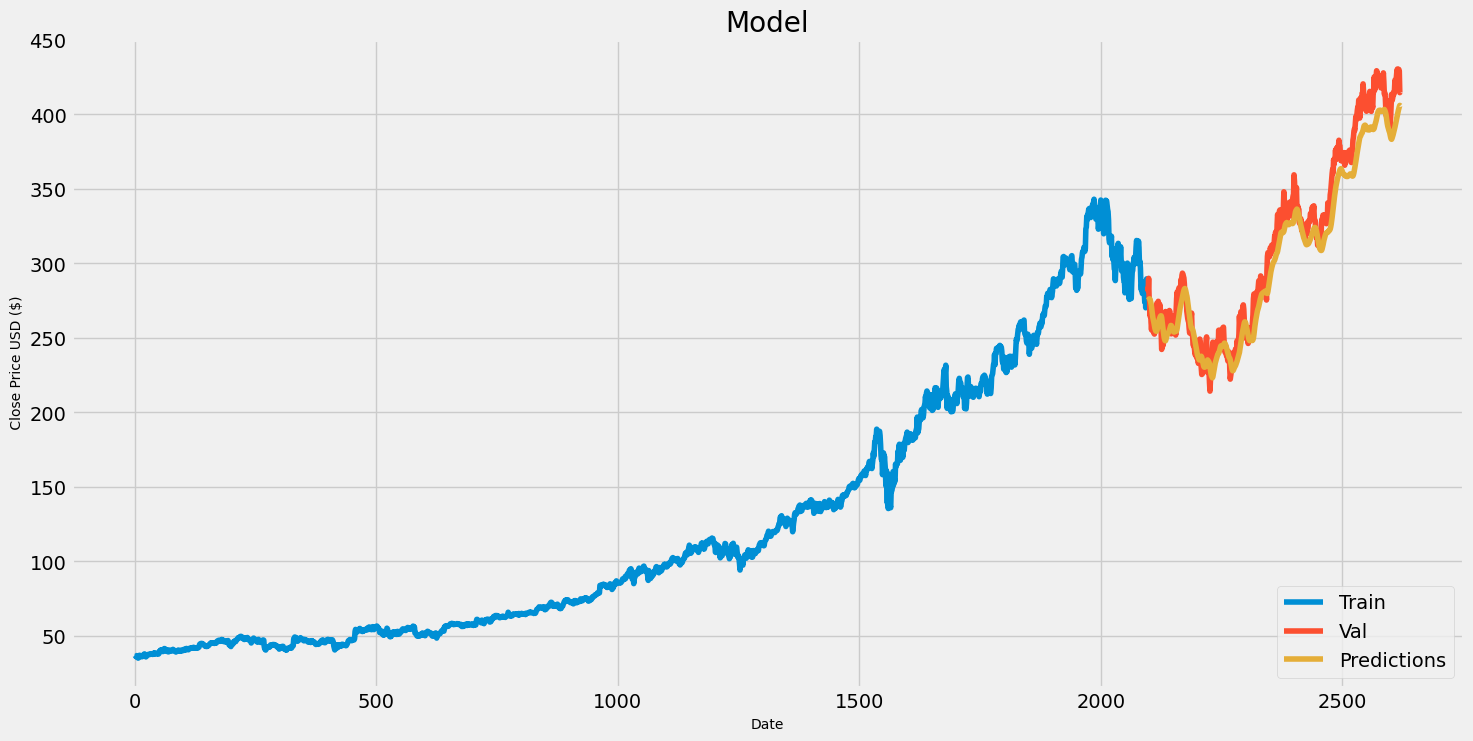

In [223]:
#Visualize train, validation and predictions as a line
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=10)
plt.ylabel(' Close Price USD ($)' , fontsize=10)
plt.plot(train['Close'])
plt.plot(valid[['Close','predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

The above plot shoes our predictions are descent closely following the actual trand line for the validation data

## Main Objective Achievement:

Goal: The primary objective was to accurately predict stock closing prices using LSTM-based models.

Outcome: The models, especially the Basic LSTM, provided reasonably accurate predictions, achieving the analysis goal.

## Model Flaws and Action Plan:

Flaws:

    Limited feature set impacting model accuracy.

    Dependency on historical data, potentially limiting future predictions.
    
Action Plan:
        
    Enhanced Feature Engineering: Incorporating additional technical indicators such as computing moving averages.
        
    Data Augmentation: Using techniques to increase the diversity of training data and improve model robustness.
    
Suggestions for Next Steps:
        
    Cross-Validation: Implementing k-fold cross-validation to ensure model reliability and avoid overfitting.
        
    Feature Expansion: Introducing new features like trading volume, sentiment analysis, or external economic indicators to enhance predictive capabilities.
        
    Model Monitoring: Continuously monitoring the model's performance with new data and fine-tuning it as necessary to maintain accuracy.

In summary, the analysis successfully identified the Basic LSTM as the most effective model for predicting stock closing prices, highlighted potential areas for improvement, and provided actionable steps for future enhancements.